In [2]:
import scirpy as ir

In [6]:
import pandas as pd

In [17]:
import matplotlib.pyplot as plt

In [45]:
## Not a part of the data, just use the adata file written in this notebook.
adata_scirpy = ir.io.read_tracer("220109_Smartseq3xpress_PBMC_SeqAmp_M462_donor6_7_8/zUMIs_10nt/tracer_output/")

In [49]:
metadata_df = pd.read_csv('data/PBMCs.allruns.barcode_annotation.txt', sep='\t')
metadata_df = metadata_df[metadata_df['donor'] == 'donor7']
metadata_df = metadata_df[metadata_df['QC_status'] == 'QCpass']
metadata_df.index = metadata_df['barcode']

In [58]:
adata_scirpy.obs_names = [cell.split('.')[1] for cell in adata_scirpy.obs_names]

In [60]:
adata_scirpy = adata_scirpy[metadata_df.index]

In [68]:
ir.tl.chain_qc(adata_scirpy)

/home/nbserver/anaconda3/lib/python3.7/site-packages/scirpy/_tools/_chain_qc.py:162: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[col_receptor_type] = res_receptor_type


In [73]:
adata_scirpy.obs = adata_scirpy.obs.join(metadata_df)

In [92]:
XCI_file = 'data/PBMC_donor7/vireo_out/donor_ids.tsv'
vireo_df = pd.read_csv(XCI_file, sep='\t', index_col=0)

In [96]:
vireo_df = vireo_df.reindex(metadata_df.index)

In [98]:
adata_scirpy.obs = adata_scirpy.obs.join(vireo_df)

In [78]:
ir.pp.ir_dist(adata_scirpy)

In [205]:
ir.tl.define_clonotypes(adata_scirpy, receptor_arms="all", dual_ir="any")

  0%|          | 0/1779 [00:00<?, ?it/s]

In [305]:
ir.tl.clonotype_network(adata_scirpy, min_cells=2, base_size=1, size_power=1)

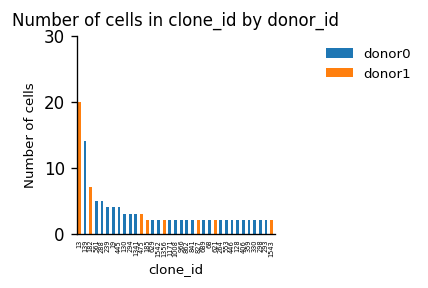

In [335]:
ax = ir.pl.group_abundance(
    adata_scirpy[adata_scirpy.obs['clone_id_size'] > 1], groupby="clone_id", target_col="donor_id", max_cols=100, figsize=(5, 3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
clone_order = ax.get_xticklabels()
ax.tick_params(axis='x', which='major', labelsize=4)
ax.tick_params(axis='x', which='minor', labelsize=4)
ax.set_ylim((0,30))
ax.set_box_aspect(1)
plt.savefig('figures/Supp_Fig_3B_Donor_7.pdf')
plt.show()

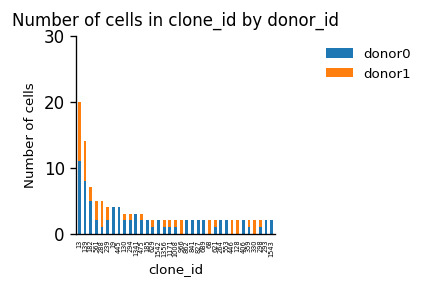

In [333]:
ax = ir.pl.group_abundance(
    adata_scirpy_shuffled[adata_scirpy_shuffled.obs['clone_id_size'] > 1], groupby="clone_id", target_col="donor_id", max_cols=100, figsize=(6, 3)
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

ax.tick_params(axis='x', which='major', labelsize=4)
ax.tick_params(axis='x', which='minor', labelsize=4)
ax.set_ylim((0,30))
ax.set_box_aspect(1)
plt.savefig('figures/Supp_Fig_3C_Donor_7.pdf')
plt.show()

In [336]:
XCI_status_per_clone = adata_scirpy.obs.groupby('clone_id').apply(lambda df2: df2.groupby('donor_id').count())['multi_chain'].to_frame()
def rotate_colors(rgb_list):
    while True:
        for rgb in rgb_list:
            yield rgb
clones_in_order = [t.get_text() for t in clone_order]
clone_size_series = adata_scirpy[adata_scirpy.obs['clone_id_size'] > 1].obs.groupby('clone_id').count().sort_values('multi_chain')['multi_chain']

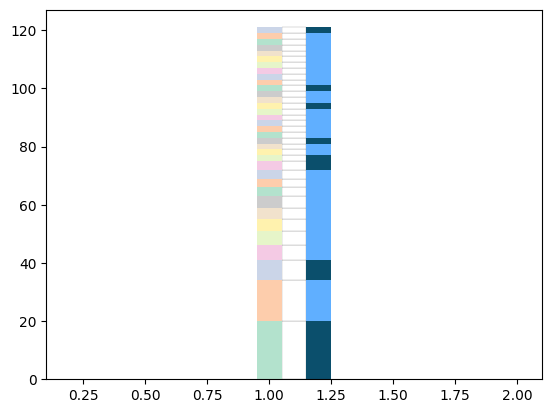

In [338]:
it = rotate_colors(plt.cm.Pastel2.colors)
bottom_1 = 0
bottom_2 = 0
for clone_id in clones_in_order:
    color = next(it)
    plt.bar(1.1, clone_size_series[clone_id], 0.1,bottom_1, linewidth=0.1, edgecolor='black', color='white')
    plt.bar(1, clone_size_series[clone_id], 0.1, bottom_1, color=color)
    
    if clone_id == '386':
        print(bottom_1)
    bottom_1 += clone_size_series[clone_id]
    df_subset = XCI_status_per_clone.loc[clone_id]
    for d in ['donor0', 'donor1', 'unassigned']:
        n = df_subset.loc[d]['multi_chain']
        if n == 0:
            continue
        color = '#60AFFF' if d == 'donor0' else '#0B4F6C'
        if d == 'unassigned':
            color = '#A5A6A9'
        plt.bar(1.2, n, 0.1, bottom_2, color=color)
        bottom_2 += n
plt.xlim((0.1,2.1))
plt.savefig('figures/Fig2C_Donor_7.pdf')
plt.show()

In [331]:
adata_scirpy.write_h5ad('data/Donor7_scirpy.h5ad')